Mount Drive + set your base paths

In [19]:
from google.colab import drive
drive.mount("/content/drive")

import os, glob, json, random
from collections import Counter, defaultdict

DRIVE_ROOT = "/content/drive/MyDrive/weather_robust_bdd_v2"
ARCHIVE = os.path.join(DRIVE_ROOT, "archive (1)")

IMG_100K = os.path.join(ARCHIVE, "bdd100k", "bdd100k", "images", "100k")
LBL_DIR  = os.path.join(ARCHIVE, "bdd100k_labels_release", "bdd100k", "labels")

TRAIN_JSON = os.path.join(LBL_DIR, "bdd100k_labels_images_train.json")
VAL_JSON   = os.path.join(LBL_DIR, "bdd100k_labels_images_val.json")

EDA_DIR     = os.path.join(DRIVE_ROOT, "eda")
SPLITS_DIR  = os.path.join(DRIVE_ROOT, "splits")
YOLO_ROOT   = os.path.join(DRIVE_ROOT, "processed_yolo")
RUNS_DIR    = os.path.join(DRIVE_ROOT, "runs")

print("IMG_100K:", IMG_100K)
print("LBL_DIR :", LBL_DIR)
print("TRAIN_JSON:", TRAIN_JSON)
print("VAL_JSON  :", VAL_JSON)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
IMG_100K: /content/drive/MyDrive/weather_robust_bdd_v2/archive (1)/bdd100k/bdd100k/images/100k
LBL_DIR : /content/drive/MyDrive/weather_robust_bdd_v2/archive (1)/bdd100k_labels_release/bdd100k/labels
TRAIN_JSON: /content/drive/MyDrive/weather_robust_bdd_v2/archive (1)/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json
VAL_JSON  : /content/drive/MyDrive/weather_robust_bdd_v2/archive (1)/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json


Verify images are actually present (recursive, supports trainA/testB etc.)

In [20]:
def assert_exists(p, name):
    if not os.path.exists(p):
        raise RuntimeError(f"Missing {name}: {p}")

assert_exists(IMG_100K, "IMG_100K")
assert_exists(LBL_DIR, "LBL_DIR")
assert_exists(TRAIN_JSON, "TRAIN_JSON")
assert_exists(VAL_JSON, "VAL_JSON")

def list_imgs_recursive(split_dir):
    return sorted(glob.glob(os.path.join(split_dir, "**", "*.jpg"), recursive=True))

train_img_dir = os.path.join(IMG_100K, "train")
val_img_dir   = os.path.join(IMG_100K, "val")

assert_exists(train_img_dir, "train images dir")
assert_exists(val_img_dir, "val images dir")

train_imgs = list_imgs_recursive(train_img_dir)
val_imgs   = list_imgs_recursive(val_img_dir)

print("Train images:", len(train_imgs))
print("Val images  :", len(val_imgs))
print("Sample train:", train_imgs[0] if train_imgs else None)
print("Sample val  :", val_imgs[0] if val_imgs else None)

train_lookup = {os.path.basename(p): p for p in train_imgs}
val_lookup   = {os.path.basename(p): p for p in val_imgs}


Train images: 70015
Val images  : 10000
Sample train: /content/drive/MyDrive/weather_robust_bdd_v2/archive (1)/bdd100k/bdd100k/images/100k/train/002b485a-3f6603f2.jpg
Sample val  : /content/drive/MyDrive/weather_robust_bdd_v2/archive (1)/bdd100k/bdd100k/images/100k/val/b1c66a42-6f7d68ca.jpg


EDA Part 1: Weather / Time-of-day / Scene distributions (prints)

In [21]:
def eda_counters(data):
    weather = Counter()
    tod = Counter()
    scene = Counter()
    cat = Counter()
    for it in data:
        attrs = it.get("attributes") or {}
        weather[attrs.get("weather","NA")] += 1
        tod[attrs.get("timeofday","NA")] += 1
        scene[attrs.get("scene","NA")] += 1
        for lab in (it.get("labels") or []):
            if lab.get("box2d") is not None:
                cat[lab.get("category","NA")] += 1
    return weather, tod, scene, cat

tr_weather, tr_tod, tr_scene, tr_cat = eda_counters(train_data)
va_weather, va_tod, va_scene, va_cat = eda_counters(val_data)

print("TRAIN weather:", tr_weather.most_common(10))
print("TRAIN timeofday:", tr_tod.most_common(10))
print("TRAIN scene:", tr_scene.most_common(10))
print("TRAIN top categories:", tr_cat.most_common(15))

print("\nVAL weather:", va_weather.most_common(10))
print("VAL timeofday:", va_tod.most_common(10))
print("VAL scene:", va_scene.most_common(10))
print("VAL top categories:", va_cat.most_common(15))


TRAIN weather: [('clear', 37344), ('overcast', 8770), ('undefined', 8119), ('snowy', 5549), ('rainy', 5070), ('partly cloudy', 4881), ('foggy', 130)]
TRAIN timeofday: [('daytime', 36728), ('night', 27971), ('dawn/dusk', 5027), ('undefined', 137)]
TRAIN scene: [('city street', 43516), ('highway', 17379), ('residential', 8074), ('parking lot', 377), ('undefined', 361), ('tunnel', 129), ('gas stations', 27)]
TRAIN top categories: [('car', 713211), ('traffic sign', 239686), ('traffic light', 186117), ('person', 91349), ('truck', 29971), ('bus', 11672), ('bike', 7210), ('rider', 4517), ('motor', 3002), ('train', 136)]

VAL weather: [('clear', 5346), ('overcast', 1239), ('undefined', 1157), ('snowy', 769), ('rainy', 738), ('partly cloudy', 738), ('foggy', 13)]
VAL timeofday: [('daytime', 5258), ('night', 3929), ('dawn/dusk', 778), ('undefined', 35)]
VAL scene: [('city street', 6112), ('highway', 2499), ('residential', 1253), ('undefined', 53), ('parking lot', 49), ('tunnel', 27), ('gas stati

**EDA Part 2: Object size histogram (vehicle boxes)**


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs(EDA_DIR, exist_ok=True)

VEHICLE_CATS = {"car","truck","bus","train","motorcycle","bicycle"}

W, H = 1280, 720
img_area = W * H

def bbox_rel_areas(data, vehicle_only=True, max_items=60000):
    areas = []
    n = 0
    for it in data:
        for lab in (it.get("labels") or []):
            if lab.get("box2d") is None:
                continue
            cat = lab.get("category")
            if vehicle_only and cat not in VEHICLE_CATS:
                continue
            b = lab["box2d"]
            a = max(0.0, (b["x2"]-b["x1"])) * max(0.0, (b["y2"]-b["y1"]))
            areas.append(a / img_area)
            n += 1
            if n >= max_items:
                return areas
    return areas

train_areas = bbox_rel_areas(train_data, vehicle_only=True)
val_areas   = bbox_rel_areas(val_data, vehicle_only=True)

def plot_hist(areas, title, outpath):
    plt.figure(figsize=(8,4))
    plt.hist(areas, bins=60)
    plt.title(title)
    plt.xlabel("BBox area / image area")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()

plot_hist(train_areas, "TRAIN Vehicle Object Size Distribution", os.path.join(EDA_DIR, "train_vehicle_size_hist.png"))
plot_hist(val_areas,   "VAL Vehicle Object Size Distribution",   os.path.join(EDA_DIR, "val_vehicle_size_hist.png"))

print("Saved:", os.path.join(EDA_DIR, "train_vehicle_size_hist.png"))
print("Saved:", os.path.join(EDA_DIR, "val_vehicle_size_hist.png"))
print("Train vehicle boxes used:", len(train_areas))
print("Val vehicle boxes used  :", len(val_areas))


Saved: /content/drive/MyDrive/weather_robust_bdd_v2/eda/train_vehicle_size_hist.png
Saved: /content/drive/MyDrive/weather_robust_bdd_v2/eda/val_vehicle_size_hist.png
Train vehicle boxes used: 60000
Val vehicle boxes used  : 60000


**EDA Part 3: Time-of-day vs Weather crosstab (and save CSV)**

In [23]:
import pandas as pd

def tod_weather_table(data):
    rows = []
    for it in data:
        attrs = it.get("attributes") or {}
        rows.append({
            "weather": attrs.get("weather","NA"),
            "timeofday": attrs.get("timeofday","NA")
        })
    df = pd.DataFrame(rows)
    tab = pd.crosstab(df["timeofday"], df["weather"])
    return tab

tab_train = tod_weather_table(train_data)
tab_val   = tod_weather_table(val_data)

print("TRAIN crosstab:\n", tab_train)
print("\nVAL crosstab:\n", tab_val)

tab_train.to_csv(os.path.join(EDA_DIR, "train_timeofday_vs_weather.csv"))
tab_val.to_csv(os.path.join(EDA_DIR, "val_timeofday_vs_weather.csv"))

print("Saved CSVs in:", EDA_DIR)


TRAIN crosstab:
 weather    clear  foggy  overcast  partly cloudy  rainy  snowy  undefined
timeofday                                                                
dawn/dusk   2004     15      1147            570    328    436        527
daytime    12454     48      7551           4262   2522   2862       7029
night      22884     67        72             49   2208   2249        442
undefined      2      0         0              0     12      2        121

VAL crosstab:
 weather    clear  foggy  overcast  partly cloudy  rainy  snowy  undefined
timeofday                                                                
dawn/dusk    307      1       182             95     55     74         64
daytime     1764      5      1039            638    396    422        994
night       3274      7        18              5    286    273         66
undefined      1      0         0              0      1      0         33
Saved CSVs in: /content/drive/MyDrive/weather_robust_bdd_v2/eda


**Make scaled-down splits (baseline train = CLEAR only, val = mixed, test = adverse)**

In [30]:
os.makedirs(SPLITS_DIR, exist_ok=True)

SEED = 0
random.seed(SEED)

N_TRAIN_CLEAR = 6000
N_VAL_MIXED   = 1200
N_TEST_ADVERSE= 1200

ADVERSE_WEATHERS = {"rainy","snowy","foggy"}
CLEAR_WEATHER    = "clear"

VEHICLE_CATS = {"car","truck","bus","train","motorcycle","bicycle"}

def get_weather(it):
    attrs = it.get("attributes") or {}
    return (attrs.get("weather") or "NA").lower()

def has_vehicle_box(it):
    for lab in (it.get("labels") or []):
        if lab.get("box2d") is not None and lab.get("category") in VEHICLE_CATS:
            return True
    return False

def filter_items(data, weather_set=None, weather_eq=None):
    out = []
    for it in data:
        w = get_weather(it)
        if weather_set is not None and w not in weather_set:
            continue
        if weather_eq is not None and w != weather_eq:
            continue
        if not has_vehicle_box(it):
            continue
        out.append(it)
    return out

train_clear_pool  = filter_items(train_data, weather_eq=CLEAR_WEATHER)
val_pool_all      = filter_items(val_data)  # mixed
test_adverse_pool = filter_items(val_data, weather_set=ADVERSE_WEATHERS)

print("Pool sizes:")
print("train_clear_pool :", len(train_clear_pool))
print("val_pool_all     :", len(val_pool_all))
print("test_adverse_pool:", len(test_adverse_pool))

def sample_n(pool, n):
    n = min(n, len(pool))
    return random.sample(pool, n)

# 1) Sample TEST first
split_test = sample_n(test_adverse_pool, N_TEST_ADVERSE)
test_names = set(os.path.basename(x["name"]) for x in split_test)

# 2) VAL from remaining (no overlap with test)
val_remaining = [it for it in val_pool_all if os.path.basename(it["name"]) not in test_names]
split_val = sample_n(val_remaining, N_VAL_MIXED)

# 3) TRAIN clear
split_train = sample_n(train_clear_pool, N_TRAIN_CLEAR)

def save_split(items, path):
    with open(path, "w") as f:
        json.dump(items, f)

save_split(split_train, os.path.join(SPLITS_DIR, "train_clear.json"))
save_split(split_val,   os.path.join(SPLITS_DIR, "val_mixed.json"))
save_split(split_test,  os.path.join(SPLITS_DIR, "test_adverse.json"))

print("✅ Saved splits in:", SPLITS_DIR)
print("train_clear:", len(split_train), "val_mixed:", len(split_val), "test_adverse:", len(split_test))

# sanity check
val_names = set(os.path.basename(x["name"]) for x in split_val)
print("Overlap(val,test) =", len(val_names & test_names))


Pool sizes:
train_clear_pool : 36969
val_pool_all     : 9905
test_adverse_pool: 1505
✅ Saved splits in: /content/drive/MyDrive/weather_robust_bdd_v2/splits
train_clear: 6000 val_mixed: 1200 test_adverse: 1200
Overlap(val,test) = 0


**YOLO conversion setup (1-class “vehicle”)**

In [31]:
!pip -q install pillow

from PIL import Image

os.makedirs(YOLO_ROOT, exist_ok=True)

YOLO_CLASSES = ["vehicle"]  # single class for baseline vehicle detection
CAT_TO_VEHICLE = VEHICLE_CATS  # categories merged into "vehicle" class 0

def yolo_box(box, w, h):
    x1,y1,x2,y2 = box["x1"], box["y1"], box["x2"], box["y2"]
    xc = (x1 + x2) / 2.0 / w
    yc = (y1 + y2) / 2.0 / h
    bw = (x2 - x1) / w
    bh = (y2 - y1) / h
    return xc, yc, bw, bh

def ensure_dirs():
    for s in ["train","val","test"]:
        os.makedirs(os.path.join(YOLO_ROOT, "images", s), exist_ok=True)
        os.makedirs(os.path.join(YOLO_ROOT, "labels", s), exist_ok=True)

ensure_dirs()


In [28]:
import shutil, os
if os.path.exists(YOLO_ROOT):
    shutil.rmtree(YOLO_ROOT)
os.makedirs(YOLO_ROOT, exist_ok=True)


**Convert each split to YOLO (symlink images; write labels)**

In [29]:
import os, shutil
from PIL import Image, ImageFile

# allow truncated/corrupted jpgs to load when possible
ImageFile.LOAD_TRUNCATED_IMAGES = True

def lookup_image_path(img_name):
    bn = os.path.basename(img_name)
    # train images should exist in train_lookup, val/test likely in val_lookup
    return train_lookup.get(bn) or val_lookup.get(bn)

def copy_if_missing(src, dst):
    if os.path.exists(dst):
        return
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy2(src, dst)

def get_image_size_safe(path):
    try:
        with Image.open(path) as im:
            im.load()  # force decode
            return im.size
    except Exception:
        return None

def convert_items_to_yolo(items, split_name):
    missing = 0
    bad_imgs = 0
    used_imgs = 0
    used_boxes = 0

    img_dir = os.path.join(YOLO_ROOT, "images", split_name)
    lbl_dir = os.path.join(YOLO_ROOT, "labels", split_name)
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    bad_list = []

    for it in items:
        bn = os.path.basename(it["name"])
        img_path = lookup_image_path(bn)
        if img_path is None:
            missing += 1
            continue

        out_img = os.path.join(img_dir, bn)
        out_lbl = os.path.join(lbl_dir, os.path.splitext(bn)[0] + ".txt")

        # Copy image into YOLO folder (Drive-safe)
        copy_if_missing(img_path, out_img)

        # Read image size safely
        size = get_image_size_safe(out_img)
        if size is None:
            bad_imgs += 1
            bad_list.append(out_img)
            # Remove bad copied image + label if any
            try:
                os.remove(out_img)
            except:
                pass
            if os.path.exists(out_lbl):
                try:
                    os.remove(out_lbl)
                except:
                    pass
            continue

        w, h = size

        lines = []
        for lab in (it.get("labels") or []):
            if lab.get("box2d") is None:
                continue
            if lab.get("category") not in CAT_TO_VEHICLE:
                continue

            xc, yc, bw, bh = yolo_box(lab["box2d"], w, h)
            lines.append(f"0 {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}")
            used_boxes += 1

        with open(out_lbl, "w") as f:
            f.write("\n".join(lines))

        used_imgs += 1

    # Save bad image log for report/debugging
    if bad_list:
        log_path = os.path.join(YOLO_ROOT, f"bad_images_{split_name}.txt")
        with open(log_path, "w") as f:
            f.write("\n".join(bad_list))
        print("Bad image log saved:", log_path)

    print(f"[{split_name}] used_imgs={used_imgs} used_boxes={used_boxes} missing_imgs={missing} bad_imgs_skipped={bad_imgs}")

# RECOMMENDED: delete old broken YOLO conversion once before rerun
# import shutil
# if os.path.exists(YOLO_ROOT): shutil.rmtree(YOLO_ROOT)

convert_items_to_yolo(split_train, "train")
convert_items_to_yolo(split_val,   "val")
convert_items_to_yolo(split_test,  "test")


[train] used_imgs=6000 used_boxes=62564 missing_imgs=0 bad_imgs_skipped=0
[val] used_imgs=1200 used_boxes=13241 missing_imgs=0 bad_imgs_skipped=0
[test] used_imgs=1200 used_boxes=12415 missing_imgs=0 bad_imgs_skipped=0


**Write YOLO yaml files (one for val, one for test)**

In [32]:
data_yaml_val = os.path.join(YOLO_ROOT, "data_val.yaml")
with open(data_yaml_val, "w") as f:
    f.write(f"path: {YOLO_ROOT}\n")
    f.write("train: images/train\n")
    f.write("val: images/val\n")
    f.write("nc: 1\n")
    f.write("names:\n  - vehicle\n")

data_yaml_test = os.path.join(YOLO_ROOT, "data_test.yaml")
with open(data_yaml_test, "w") as f:
    f.write(f"path: {YOLO_ROOT}\n")
    f.write("train: images/train\n")
    f.write("val: images/test\n")   # treat test as val for metrics run
    f.write("nc: 1\n")
    f.write("names:\n  - vehicle\n")

print("Saved:", data_yaml_val)
print("Saved:", data_yaml_test)


Saved: /content/drive/MyDrive/weather_robust_bdd_v2/processed_yolo/data_val.yaml
Saved: /content/drive/MyDrive/weather_robust_bdd_v2/processed_yolo/data_test.yaml


**Install YOLOv8 + confirm GPU**

In [34]:
!pip -q install ultralytics

import torch, shutil

gpu = torch.cuda.is_available()
print("CUDA available:", gpu)

if gpu and shutil.which("nvidia-smi"):
    !nvidia-smi -L
else:
    print("No GPU detected. If you want GPU: Runtime → Change runtime type → GPU (T4)")


CUDA available: False
No GPU detected. If you want GPU: Runtime → Change runtime type → GPU (T4)


**Train baseline model (clear-weather training)**

In [35]:
from ultralytics import YOLO
import os

os.makedirs(RUNS_DIR, exist_ok=True)

model = YOLO("yolov8n.pt")  # lightweight baseline

results = model.train(
    data=data_yaml_val,
    epochs=20,
    imgsz=640,
    batch=16,
    device=0,
    project=RUNS_DIR,
    name="baseline_clear_vehicle",
    exist_ok=True
)

run_dir = os.path.join(RUNS_DIR, "baseline_clear_vehicle")
best_pt = os.path.join(run_dir, "weights", "best.pt")
print("Run dir:", run_dir)
print("Best weights:", best_pt)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/weather_robust_bdd_v2/processed_yolo/data_val.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.

**Evaluate on VAL (mixed weather)**

In [37]:
best_model = YOLO(best_pt)

val_metrics = best_model.val(
    data=data_yaml_val,
    imgsz=640,
    device="cpu"
)

print("✅ VAL evaluation done")
print(val_metrics)


Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 25.6±13.0 MB/s, size: 71.0 KB)
val: Scanning /content/drive/MyDrive/weather_robust_bdd_v2/processed_yolo/labels/val.cache... 1200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1200/1200 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 75/75 3.1s/it 3:53
                   all       1200      13241      0.766       0.55      0.644      0.378
Speed: 4.0ms preprocess, 163.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/runs/detect/val2
✅ VAL evaluation done
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7870dced

**Evaluate on TEST (adverse weather)**

In [38]:
test_metrics = best_model.val(
    data=data_yaml_test,
    imgsz=640,
    device="cpu"
)

print("✅ TEST (adverse) evaluation done")
print(test_metrics)


Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.8±0.2 ms, read: 13.8±5.0 MB/s, size: 52.5 KB)
val: Scanning /content/drive/MyDrive/weather_robust_bdd_v2/processed_yolo/labels/test... 1200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1200/1200 46.3it/s 25.9s
val: New cache created: /content/drive/MyDrive/weather_robust_bdd_v2/processed_yolo/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 75/75 2.9s/it 3:35
                   all       1200      12415      0.776      0.533      0.631       0.37
Speed: 2.6ms preprocess, 159.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/runs/detect/val3
✅ TEST (adverse) evaluation done
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.Confusio

**Weather-wise Evaluation + Plot**

torch: 2.9.0+cpu
CUDA available: False
Using DEVICE: cpu


Preparing weather_clear: 100%|██████████| 150/150 [00:22<00:00,  6.81it/s]

weather_clear: copied=150, missing_images=0
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 670.0±312.6 MB/s, size: 47.3 KB)


val: Scanning /content/tmp_eval_weather/weather_clear/labels/val... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 1.7Kit/s 0.1s
val: New cache created: /content/tmp_eval_weather/weather_clear/labels/val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 2.8s/it 28.2s
                   all        150       1503      0.766      0.546      0.645      0.374
Speed: 2.6ms preprocess, 164.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/runs/detect/val5
✅ clear {'mAP50': 0.6448962677524693, 'mAP50_95': 0.37365627865915735, 'n': 150}


Preparing weather_undefined: 100%|██████████| 150/150 [00:56<00:00,  2.65it/s]

weather_undefined: copied=150, missing_images=0
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1368.7±519.1 MB/s, size: 58.6 KB)
val: Scanning /content/tmp_eval_weather/weather_undefined/labels/val... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 1.9Kit/s 0.1s
val: New cache created: /content/tmp_eval_weather/weather_undefined/labels/val.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 2.7s/it 26.7s
                   all        150       1735      0.802       0.58      0.685      0.419
Speed: 2.1ms preprocess, 160.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/runs/detect/val6
✅ undefined {'mAP50': 0.6854307082545207, 'mAP50_95': 0.4194632604098011, 'n': 150}


Preparing weather_partly cloudy: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]

weather_partly cloudy: copied=98, missing_images=0
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1544.0±560.6 MB/s, size: 85.2 KB)
val: Scanning /content/tmp_eval_weather/weather_partly cloudy/labels/val... 98 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 98/98 1.7Kit/s 0.1s
val: New cache created: /content/tmp_eval_weather/weather_partly cloudy/labels/val.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.7s/it 19.2s
                   all         98       1219      0.806      0.543      0.635      0.392
Speed: 5.2ms preprocess, 169.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/runs/detect/val7
✅ partly cloudy {'mAP50': 0.635101881465332, 'mAP50_95': 0.39182392105190866, 'n': 98}


Preparing weather_overcast: 100%|██████████| 150/150 [00:38<00:00,  3.90it/s]

weather_overcast: copied=150, missing_images=0
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1478.6±371.9 MB/s, size: 63.0 KB)
val: Scanning /content/tmp_eval_weather/weather_overcast/labels/val... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 2.0Kit/s 0.1s
val: New cache created: /content/tmp_eval_weather/weather_overcast/labels/val.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 2.7s/it 27.5s
                   all        150       1992       0.77      0.578      0.649      0.396
Speed: 3.3ms preprocess, 164.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/runs/detect/val8
✅ overcast {'mAP50': 0.6487559285935708, 'mAP50_95': 0.3964758651833283, 'n': 150}
Saved: /content/drive/MyDrive/weather_robust_bdd_v2/eda/map_by_weather_cpu.csv
         weather     mAP50  mAP50_95    n
1      undefined  0.685431  0.419463  150
3       overcast  0.648756  0.396476  150
0          clear  0.644896  0.373656  150
2  partly cloudy  0.635102  0.391824   98


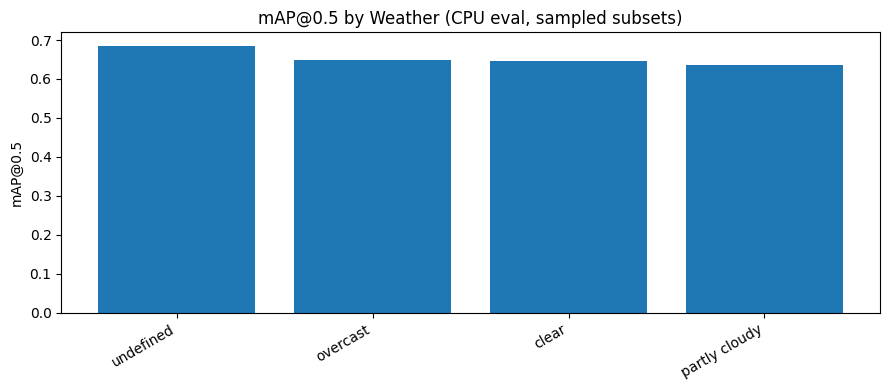

Saved: /content/drive/MyDrive/weather_robust_bdd_v2/eda/map_by_weather_cpu.png


In [50]:
from ultralytics import YOLO
import os, shutil, random
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch

# ---- CPU device ----
DEVICE = "cpu"
print("torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Using DEVICE:", DEVICE)

best_model = YOLO(best_pt)

LOCAL_EVAL_ROOT = "/content/tmp_eval_weather"
os.makedirs(LOCAL_EVAL_ROOT, exist_ok=True)

VEHICLE_CATS = {"car","truck","bus","train","motorcycle","bicycle"}

def yolo_line_from_box(box, w, h):
    x1,y1,x2,y2 = box["x1"], box["y1"], box["x2"], box["y2"]
    xc = (x1 + x2) / 2.0 / w
    yc = (y1 + y2) / 2.0 / h
    bw = (x2 - x1) / w
    bh = (y2 - y1) / h
    return f"0 {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}"

def group_by_weather(items):
    groups = {}
    for it in items:
        w = (it.get("attributes") or {}).get("weather", "NA")
        groups.setdefault(w, []).append(it)
    return groups

def find_image_path(filename):
    return val_lookup.get(filename) or train_lookup.get(filename)

def build_local_subset(items, split_name, max_n=150):
    """
    Copies images to /content and writes YOLO labels from JSON directly.
    max_n reduced because CPU eval is slower.
    """
    root = os.path.join(LOCAL_EVAL_ROOT, split_name)
    img_dir = os.path.join(root, "images", "val")
    lbl_dir = os.path.join(root, "labels", "val")

    if os.path.exists(root):
        shutil.rmtree(root)
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    items = random.sample(items, min(max_n, len(items)))

    copied = 0
    missing_img = 0

    for it in tqdm(items, desc=f"Preparing {split_name}"):
        bn = os.path.basename(it["name"])
        src_img = find_image_path(bn)
        if src_img is None:
            missing_img += 1
            continue

        dst_img = os.path.join(img_dir, bn)
        shutil.copy2(src_img, dst_img)
        copied += 1

        # write YOLO labels from JSON
        with Image.open(dst_img) as im:
            w, h = im.size

        lines = []
        for lab in (it.get("labels") or []):
            if lab.get("box2d") is None:
                continue
            if lab.get("category") not in VEHICLE_CATS:
                continue
            lines.append(yolo_line_from_box(lab["box2d"], w, h))

        dst_lbl = os.path.join(lbl_dir, os.path.splitext(bn)[0] + ".txt")
        with open(dst_lbl, "w") as f:
            f.write("\n".join(lines))

    data_yaml = os.path.join(root, "data.yaml")
    with open(data_yaml, "w") as f:
        f.write(f"path: {root}\n")
        f.write("train: images/val\n")
        f.write("val: images/val\n")
        f.write("nc: 1\n")
        f.write("names:\n  - vehicle\n")

    print(f"{split_name}: copied={copied}, missing_images={missing_img}")
    return data_yaml, copied

# -------- Run weather-wise eval (CPU) --------
random.seed(0)

groups = group_by_weather(split_val)   # your val_mixed split
weather_scores = {}

# CPU is slow -> keep smaller per-weather sample
MAX_PER_WEATHER = 150
MIN_COPIED = 30

for w, items in groups.items():
    if len(items) < MIN_COPIED:
        continue

    data_yaml, copied = build_local_subset(items, f"weather_{w}", max_n=MAX_PER_WEATHER)
    if copied < MIN_COPIED:
        print(f"Skip {w}: too few usable images ({copied})")
        continue

    m = best_model.val(
        data=data_yaml,
        imgsz=640,
        device=DEVICE,
        verbose=False
    )

    weather_scores[w] = {
        "mAP50": float(m.box.map50),
        "mAP50_95": float(m.box.map),
        "n": copied
    }
    print("✅", w, weather_scores[w])

# -------- Save + Plot --------
if not weather_scores:
    raise RuntimeError("weather_scores is empty. Try increasing split_val size or lowering MIN_COPIED.")

df = pd.DataFrame([
    {"weather": w, **weather_scores[w]} for w in weather_scores
]).sort_values("mAP50", ascending=False)

os.makedirs(EDA_DIR, exist_ok=True)
csv_path = os.path.join(EDA_DIR, "map_by_weather_cpu.csv")
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)
print(df)

plt.figure(figsize=(9,4))
plt.bar(df["weather"], df["mAP50"])
plt.title("mAP@0.5 by Weather (CPU eval, sampled subsets)")
plt.ylabel("mAP@0.5")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

plot_path = os.path.join(EDA_DIR, "map_by_weather_cpu.png")
plt.savefig(plot_path, dpi=200)
plt.show()
print("Saved:", plot_path)


**Auto-generate report.pdf (≤ 5 pages) from EDA + results**

In [39]:
import json, time

out = {
    "run_dir": run_dir,
    "best_pt": best_pt,
    "split_sizes": {
        "train_clear": len(split_train),
        "val_mixed": len(split_val),
        "test_adverse": len(split_test),
    },
    "note": "YOLOv8n baseline trained on CLEAR-weather subset; evaluated on mixed val and adverse test.",
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}

with open(os.path.join(run_dir, "experiment_summary.json"), "w") as f:
    json.dump(out, f, indent=2)

print("Saved:", os.path.join(run_dir, "experiment_summary.json"))


Saved: /content/drive/MyDrive/weather_robust_bdd_v2/runs/baseline_clear_vehicle/experiment_summary.json


**Auto-generate report.pdf (≤ 5 pages) from EDA + results**

In [40]:
!pip -q install reportlab

from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.units import cm
from reportlab.lib.utils import ImageReader

report_path = os.path.join(DRIVE_ROOT, "repo_weather_robust_bdd_v2_report.pdf")

c = canvas.Canvas(report_path, pagesize=A4)
Wpx, Hpx = A4

def title(txt):
    c.setFont("Helvetica-Bold", 14)
    c.drawString(2*cm, Hpx-2*cm, txt)

def para(y, txt, size=11):
    c.setFont("Helvetica", size)
    text = c.beginText(2*cm, y)
    for line in txt.split("\n"):
        text.textLine(line)
    c.drawText(text)

# Page 1: Overview
title("Weather Robust Object Detection on BDD100K — Report")
para(Hpx-3.2*cm,
     "Baseline: YOLOv8n trained on CLEAR-weather images to detect VEHICLE (single class).\n"
     "EDA: weather/time/scene trends, time-of-day vs weather crosstab, vehicle object size histogram.\n"
     "Evaluation: metrics on mixed-weather val and adverse-weather test.\n\n"
     f"Splits used:\n"
     f"- train_clear: {len(split_train)}\n"
     f"- val_mixed  : {len(split_val)}\n"
     f"- test_adverse: {len(split_test)}\n\n"
     "Notes:\n"
     "- Training uses scaled-down data for faster iteration.\n"
     "- Vehicle categories merged: car, truck, bus, train, motorcycle, bicycle."
)
c.showPage()

# Page 2: EDA plots
title("EDA Plots")
y = Hpx-3.2*cm
plots = [
    os.path.join(EDA_DIR, "train_vehicle_size_hist.png"),
    os.path.join(EDA_DIR, "train_timeofday_vs_weather.csv"),  # show as text note
    os.path.join(EDA_DIR, "val_vehicle_size_hist.png"),
]
para(y, "Included plots saved in Drive/eda/. Key ones embedded below.\n")
y -= 1.2*cm

def draw_img(path, y):
    if os.path.exists(path):
        img = ImageReader(path)
        c.drawImage(img, 2*cm, y-8*cm, width=17*cm, height=8*cm, preserveAspectRatio=True, anchor='sw')
        return y-8.6*cm
    else:
        para(y, f"[Missing image: {path}]")
        return y-1*cm

y = draw_img(os.path.join(EDA_DIR, "train_vehicle_size_hist.png"), y)
y = draw_img(os.path.join(EDA_DIR, "val_vehicle_size_hist.png"), y)
para(2.2*cm, "Crosstab CSVs: train_timeofday_vs_weather.csv, val_timeofday_vs_weather.csv")
c.showPage()

# Page 3: Preprocessing + splits
title("Data Pre-processing & Splitting")
para(Hpx-3.2*cm,
     "WHAT:\n"
     "- Filter images containing at least one vehicle bounding box.\n"
     "- Train split uses CLEAR weather only (baseline requirement).\n"
     "- Val split is mixed weather; Test split uses adverse weather (rainy/snowy/foggy).\n"
     "- Convert BDD100K JSON labels to YOLO txt format and symlink images.\n\n"
     "WHY:\n"
     "- Scaled-down subset speeds up training while keeping meaningful trends.\n"
     "- Weather-based splits allow robustness testing under adverse conditions.\n\n"
     "HOW:\n"
     "- Splits saved in Drive/splits/ as JSON.\n"
     "- YOLO dataset saved in Drive/processed_yolo/."
)
c.showPage()

# Page 4: Training + evaluation pointers
title("Model & Evaluation")
para(Hpx-3.2*cm,
     "Model: YOLOv8n (lightweight baseline).\n"
     "Reasoning: fast to train on Colab, standard detection metrics output.\n\n"
     "Metrics:\n"
     "- mAP@0.5 and mAP@0.5:0.95 (YOLO standard)\n"
     "- Compare val (mixed) vs test (adverse) to understand weather robustness.\n\n"
     f"Artifacts:\n"
     f"- Best weights: {best_pt}\n"
     f"- Run dir: {run_dir}\n"
     f"- Summary JSON: {os.path.join(run_dir,'experiment_summary.json')}\n\n"
     "Add your final observations here (1–2 paragraphs):\n"
     "- Which weather/time segments hurt performance?\n"
     "- Does object size distribution explain misses?\n"
     "- What data/model changes could improve robustness?"
)
c.showPage()

c.save()
print("✅ Report created:", report_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.8 MB/s eta 0:00:00
✅ Report created: /content/drive/MyDrive/weather_robust_bdd_v2/repo_weather_robust_bdd_v2_report.pdf


In [41]:
REPO_DIR = os.path.join(DRIVE_ROOT, "repo_weather_robust_bdd_v2")
os.makedirs(REPO_DIR, exist_ok=True)

# Save a minimal README (edit before pushing)
readme_path = os.path.join(REPO_DIR, "README.md")
with open(readme_path, "w") as f:
    f.write(
        "# Weather Robust Object Detection on BDD100K (YOLOv8)\n\n"
        "## Setup\n"
        "```bash\npip install ultralytics pillow matplotlib pandas reportlab\n```\n\n"
        "## Data\n"
        "Dataset is stored on Google Drive (not included in repo).\n\n"
        "## Run (Colab)\n"
        "- Run cells in order: mount → verify → EDA → splits → YOLO conversion → train → eval.\n\n"
        "## Outputs\n"
        "- EDA: `weather_robust_bdd_v2/eda/`\n"
        "- Splits: `weather_robust_bdd_v2/splits/`\n"
        "- YOLO: `weather_robust_bdd_v2/processed_yolo/`\n"
        "- Runs: `weather_robust_bdd_v2/runs/`\n"
        "- Report: `repo_weather_robust_bdd_v2_report.pdf`\n"
    )

# Copy report into repo folder for easy push
import shutil
shutil.copy(report_path, os.path.join(REPO_DIR, "report.pdf"))

print("Repo folder ready:", REPO_DIR)
print("Contains:", os.listdir(REPO_DIR))


Repo folder ready: /content/drive/MyDrive/weather_robust_bdd_v2/repo_weather_robust_bdd_v2
Contains: ['README.md', 'report.pdf']
